# TP de Synthèse — Intelligence Artificielle avec Python

**Objectif**
Ce notebook guide pas à pas l'analyse exploratoire, le pré‑traitement, la modélisation et la génération du fichier de soumission pour le TP "Hotel Reservations" (prédire `booking_status` : `Canceled` vs `Not_canceled`).


## Plan
1. Imports et réglages
2. Chargement des données
3. EDA (statistiques, graphiques)
4. Prétraitement (gestion des NaN, encodages, feature engineering)
5. Baselines & splits
6. Modèles à tester (LogisticRegression, RandomForest, XGBoost/LightGBM, SVM)
7. Validation croisée stratifiée et recherche d'hyperparamètres
8. Sélection du meilleur modèle et calibration
9. Génération du fichier de soumission
10. Pistes d'amélioration & considérations éthiques/légales

# 1) Imports et réglages



In [16]:
# Imports de base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# modèles
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# xgboost est recommandé si tu l'as
try:
    import xgboost as xgb
    has_xgb = True
except Exception:
    has_xgb = False

# Optionnel : SMOTE pour class imbalance
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    has_smote = True
except Exception:
    has_smote = False

# affichage
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (10,5)

# seed
RANDOM_STATE = 42

# 2) Chargement des données

In [5]:
train = pd.read_csv('data/Hotel Reservations.csv')
test = pd.read_csv('data/Donnees_Test.csv')

print('train shape', train.shape)
print('test shape', test.shape)

train.head()

train shape (29999, 19)
test shape (6276, 18)


Booking_ID  no_of_adults  no_of_children  no_of_weekend_nights  \
0   INN00001             2               0                     1   
1   INN00002             2               0                     2   
2   INN00003             1               0                     2   
3   INN00004             2               0                     0   
4   INN00005             2               0                     1   

   no_of_week_nights type_of_meal_plan  required_car_parking_space  \
0                  2       Meal Plan 1                           0   
1                  3      Not Selected                           0   
2                  1       Meal Plan 1                           0   
3                  2       Meal Plan 1                           0   
4                  1      Not Selected                           0   

  room_type_reserved  lead_time  arrival_year  arrival_month  arrival_date  \
0        Room_Type 1        224          2017             10             2   
1        Room_Type 1          5          2018             11             6   
2        Room_Type 1          1          2018              2            28   
3        Room_Type 1        211          2018              5            20   
4        Room_Type 1         48          2018              4            11   

  market_segment_type  repeated_guest  no_of_previous_cancellations  \
0             Offline               0                             0   
1              Online               0                             0   
2              Online               0                             0   
3              Online               0                             0   
4              Online               0                             0   

   no_of_previous_bookings_not_canceled  avg_price_per_room  \
0                                     0               65.00   
1                                     0              106.68   
2                                     0               60.00   
3                                     0              100.00   
4                                     0               94.50   

   no_of_special_requests booking_status  
0                       0   Not_Canceled  
1                       1   Not_Canceled  
2                       0       Canceled  
3                       0       Canceled  
4                       0       Canceled

Vérifie que les colonnes correspondent et que `booking_status` est présente dans `train` et absente dans `test`.

# 3) EDA (exploration)

In [6]:
# Nombre d'attributs, lignes, classes
print('n_attributs:', train.shape[1])
print('n_lignes:', train.shape[0])
print('\nclasses distribution:')
print(train['booking_status'].value_counts())
print(train['booking_status'].value_counts(normalize=True))

# Valeurs manquantes
missing = train.isna().sum().sort_values(ascending=False)
print('\nMissing values (train):')
print(missing[missing>0])

# Statistiques numériques
train.describe().T

n_attributs: 19
n_lignes: 29999

classes distribution:
booking_status
Not_Canceled    20184
Canceled         9815
Name: count, dtype: int64
booking_status
Not_Canceled    0.672822
Canceled        0.327178
Name: proportion, dtype: float64

Missing values (train):
Series([], dtype: int64)


count         mean        std     min  \
no_of_adults                          29999.0     1.845862   0.518453     0.0   
no_of_children                        29999.0     0.105037   0.403747     0.0   
no_of_weekend_nights                  29999.0     0.806127   0.868561     0.0   
no_of_week_nights                     29999.0     2.202140   1.402214     0.0   
required_car_parking_space            29999.0     0.031301   0.174133     0.0   
lead_time                             29999.0    85.503217  86.072456     0.0   
arrival_year                          29999.0  2017.821894   0.382608  2017.0   
arrival_month                         29999.0     7.428548   3.064046     1.0   
arrival_date                          29999.0    15.583819   8.723316     1.0   
repeated_guest                        29999.0     0.025668   0.158144     0.0   
no_of_previous_cancellations          29999.0     0.022701   0.353166     0.0   
no_of_previous_bookings_not_canceled  29999.0     0.155139   1.771725     0.0   
avg_price_per_room                    29999.0   103.412309  35.043692     0.0   
no_of_special_requests                29999.0     0.620687   0.787359     0.0   

                                         25%      50%     75%     max  
no_of_adults                             2.0     2.00     2.0     4.0  
no_of_children                           0.0     0.00     0.0    10.0  
no_of_weekend_nights                     0.0     1.00     2.0     7.0  
no_of_week_nights                        1.0     2.00     3.0    17.0  
required_car_parking_space               0.0     0.00     0.0     1.0  
lead_time                               17.0    57.00   127.0   443.0  
arrival_year                          2018.0  2018.00  2018.0  2018.0  
arrival_month                            5.0     8.00    10.0    12.0  
arrival_date                             8.0    16.00    23.0    31.0  
repeated_guest                           0.0     0.00     0.0     1.0  
no_of_previous_cancellations             0.0     0.00     0.0    13.0  
no_of_previous_bookings_not_canceled     0.0     0.00     0.0    58.0  
avg_price_per_room                      80.5    99.45   120.0   375.5  
no_of_special_requests                   0.0     0.00     1.0     5.0

Graphiques utiles :

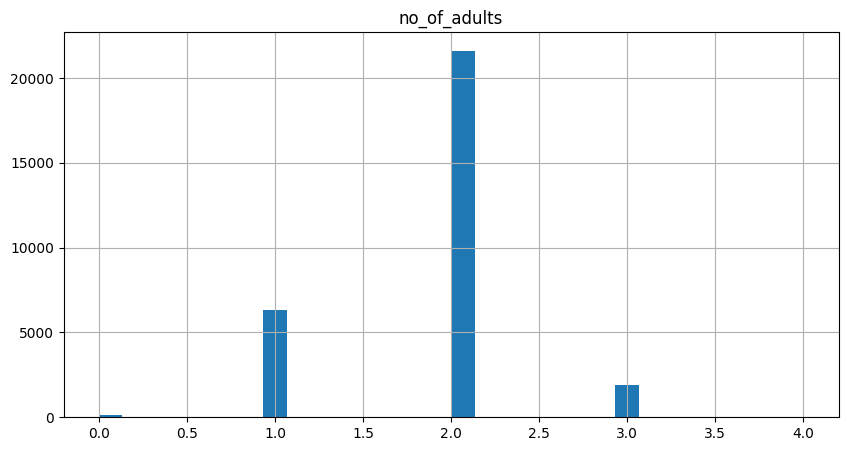

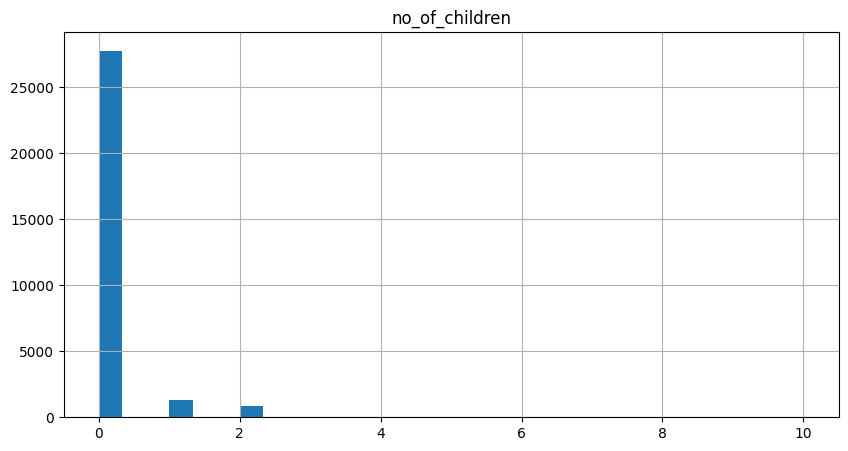

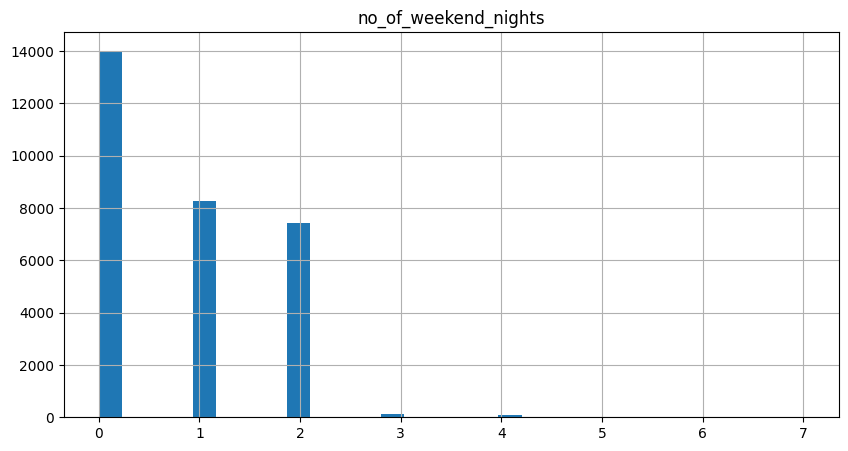

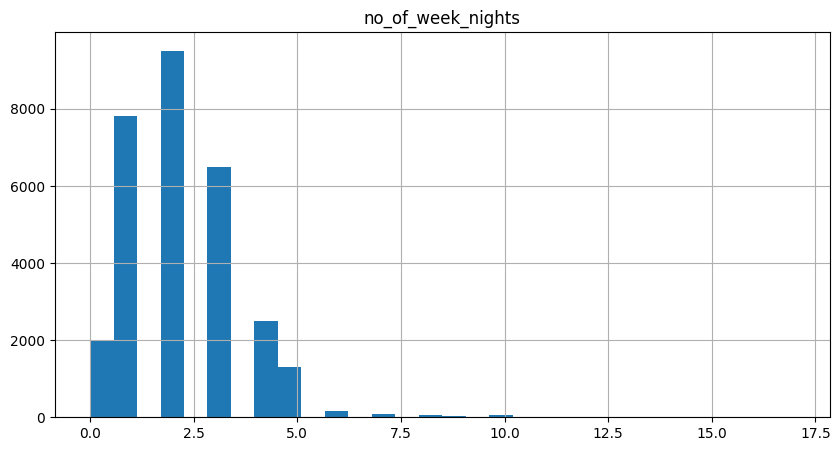

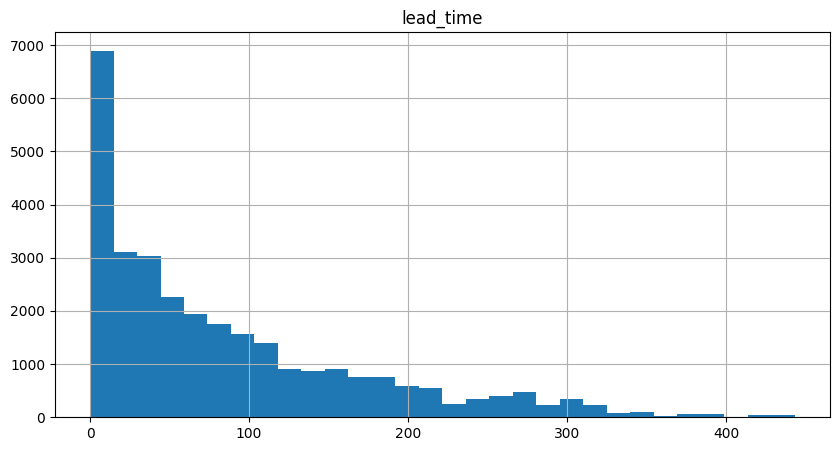

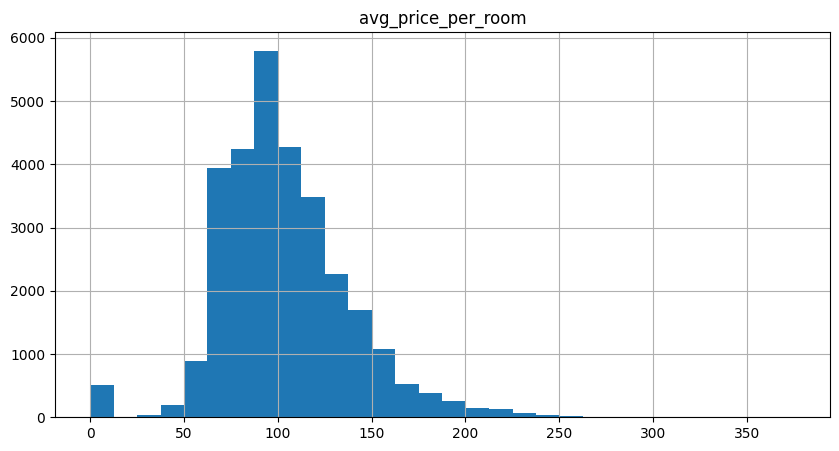

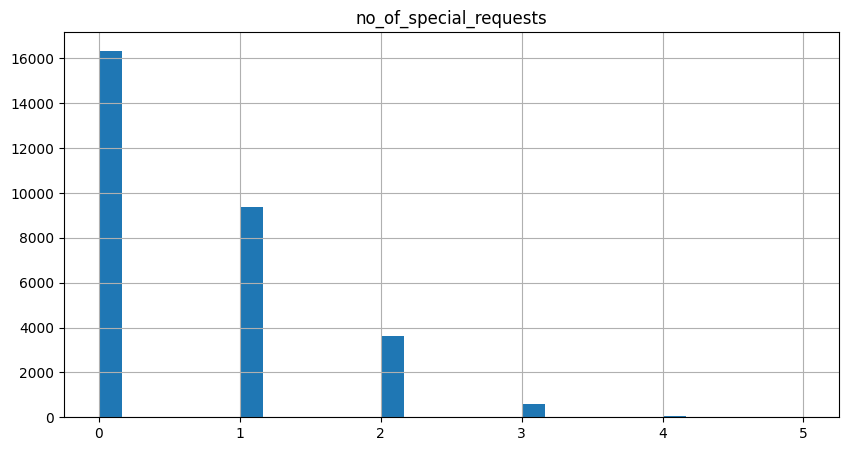

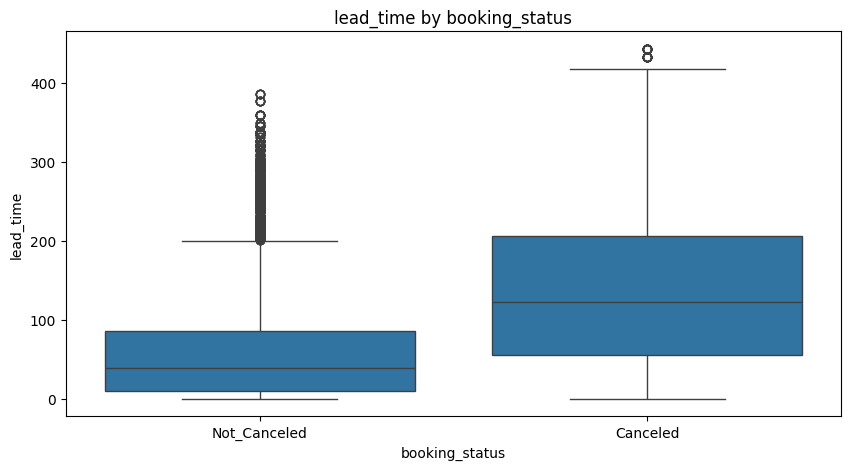

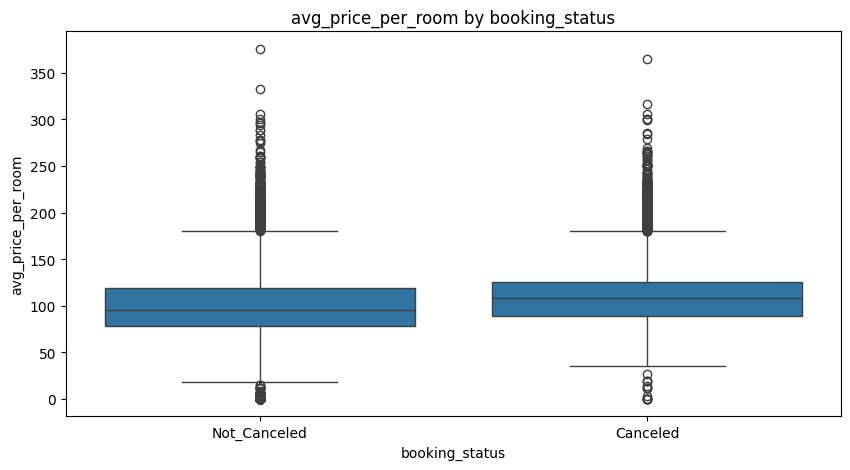

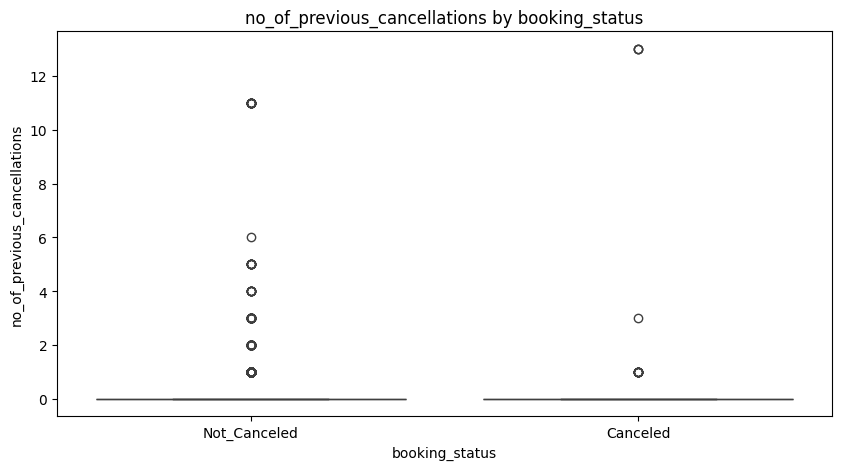

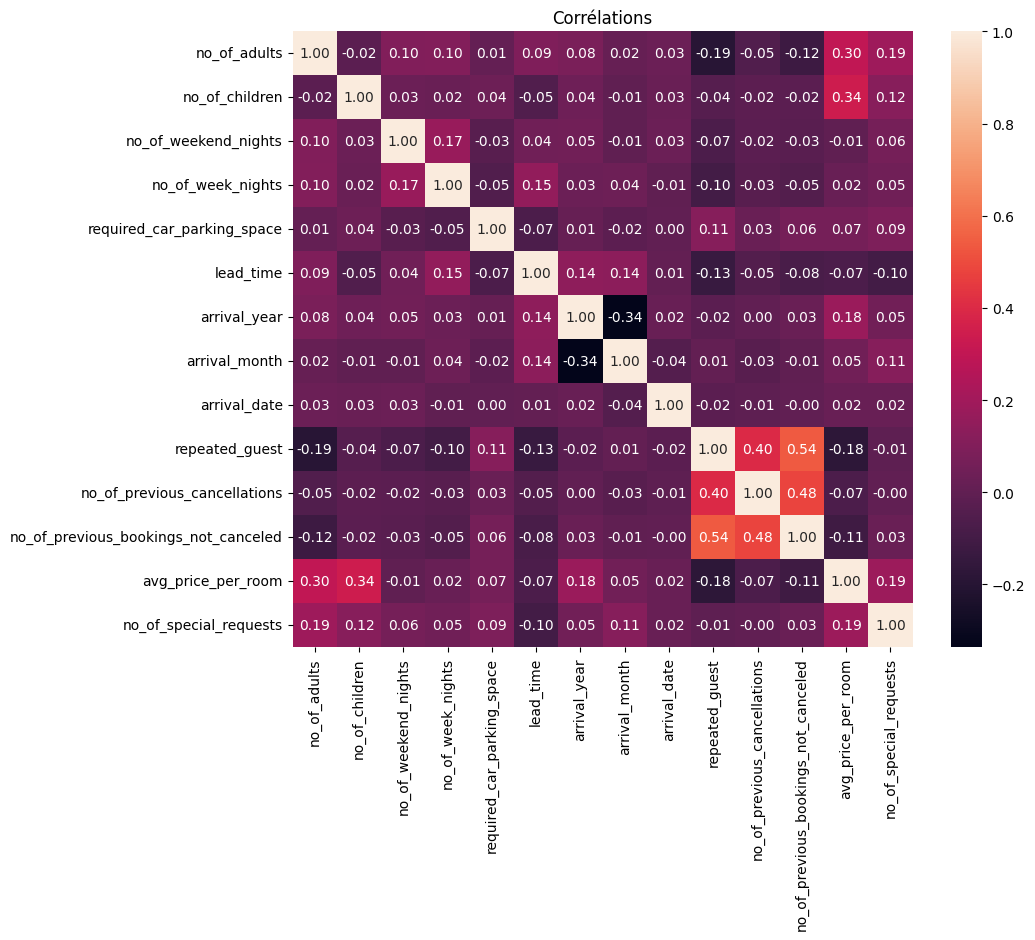

In [8]:
# histogrammes pour colonnes numériques importantes
num_cols = ['no_of_adults','no_of_children','no_of_weekend_nights','no_of_week_nights','lead_time','avg_price_per_room','no_of_special_requests']
for c in num_cols:
    train[c].hist(bins=30)
    plt.title(c)
    plt.show()

# boxplots par booking_status
import seaborn as sns
for c in ['lead_time','avg_price_per_room','no_of_previous_cancellations']:
    sns.boxplot(x='booking_status', y=c, data=train)
    plt.title(c + ' by booking_status')
    plt.show()

# heatmap corrélations numériques
plt.figure(figsize=(10,8))
num = train.select_dtypes(include=[np.number])
sns.heatmap(num.corr(), annot=True, fmt='.2f')
plt.title('Corrélations')
plt.show()

> Cherche des corrélations fortes, multicolinéarité (par ex. `no_of_week_nights` + `no_of_weekend_nights` ↔ `avg_price_per_room`), et des outliers.

# 4) Prétraitement & Feature Engineering

Idées :
- Combiner `no_of_weekend_nights + no_of_week_nights` -> `total_nights`
- Créer `total_people = no_of_adults + no_of_children`
- Transformer `arrival_month` en cyclical features (sin/cos) si utile
- Group rare categories in `room_type_reserved` or `market_segment_type`
- Encodage: OneHot pour variables catégorielles à faible cardinalité, Target/Ordinal pour d'autres
- Normalisation: StandardScaler pour modèles linéaires

In [11]:
# exemple de pipeline simplifié
train = train.copy()
train['total_nights'] = train['no_of_weekend_nights'] + train['no_of_week_nights']
train['total_people'] = train['no_of_adults'] + train['no_of_children']

# cyclical month
train['month_sin'] = np.sin(2*np.pi*train['arrival_month']/12)
train['month_cos'] = np.cos(2*np.pi*train['arrival_month']/12)

Sépare X / y :

In [12]:
X = train.drop(columns=['booking_status','Booking_ID'])
y = train['booking_status'].map({'Canceled':1, 'Not_canceled':0})

Définir colonnes numériques et catégorielles :

In [13]:
num_features = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object','category']).columns.tolist()

Pipeline exemple :

In [24]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

Si tu veux utiliser SMOTE : utilise `ImbPipeline` pour inclure sur‑échantillonnage seulement sur le jeu d'entraînement.

# 5) Baseline & Split

In [28]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

# Baseline Dummy
dummy = Pipeline(steps=[('pre', preprocessor), ('clf', DummyClassifier(strategy='most_frequent'))])
dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_val)
print('Dummy accuracy:', accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))

Dummy accuracy: 1.0
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      1963

    accuracy                           1.00      1963
   macro avg       1.00      1.00      1.00      1963
weighted avg       1.00      1.00      1.00      1963



# 6) Modèles & évaluation

Pistes : LogisticRegression (avec `class_weight='balanced'`), RandomForest, XGBoost.

In [33]:
# %% Logistic Regression pipeline
lr_pipe = Pipeline(steps=[('pre', preprocessor), ('clf', LogisticRegression(max_iter=2000, class_weight='balanced', random_state=RANDOM_STATE))])

lr_pipe.fit(X_train, y_train)
yp = lr_pipe.predict(X_val)
print('LR accuracy:', accuracy_score(y_val, yp))
print(classification_report(y_val, yp))

# RandomForest
rf_pipe = Pipeline(steps=[('pre', preprocessor), ('clf', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=RANDOM_STATE))])
rf_pipe.fit(X_train, y_train)
yp_rf = rf_pipe.predict(X_val)
print('RF accuracy:', accuracy_score(y_val, yp_rf))
print(classification_report(y_val, yp_rf))

# XGBoost (si disponible)
if has_xgb:
    xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE)
    xgb_pipe = Pipeline(steps=[('pre', preprocessor), ('clf', xgb_clf)])
    xgb_pipe.fit(X_train, y_train)
    yp_xgb = xgb_pipe.predict(X_val)
    print('XGB accuracy:', accuracy_score(y_val, yp_xgb))
    print(classification_report(y_val, yp_xgb))

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: np.float64(1.0)